<a href="https://colab.research.google.com/github/rakesh-sengupta/qrnn/blob/main/qRNN_RS_v3_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install qutip

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.1/30.1 MB 67.2 MB/s eta 0:00:00


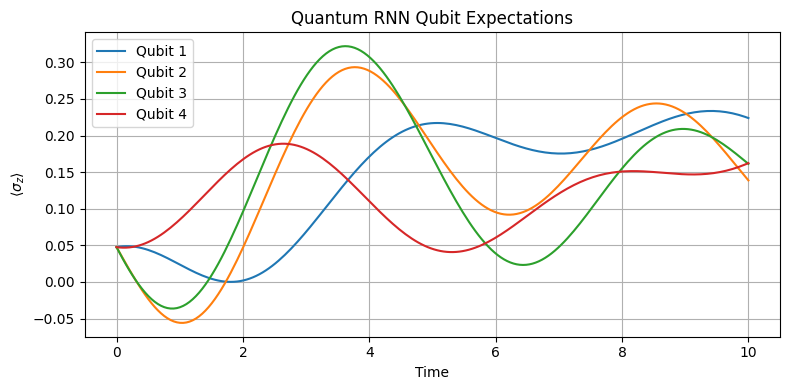

In [24]:
import numpy as np
from scipy.integrate import solve_ivp
import qutip
from typing import List, Callable

class QuantumRNN:
    """
    Quantum Recurrent Neural Network (QRNN) with:
      - Hermitian Hamiltonian (decay, activation, beta-weighted interactions, input)
      - Lindblad noise (amplitude damping + dephasing)
      - Hybrid quantum-classical activation
    """
    def __init__(
        self,
        num_qubits: int,
        delta: float,
        alpha: float,
        beta: float,
        J: np.ndarray,
        lambda_activation: float,
        gamma_amp: float,
        gamma_deph: float
    ):
        """
        Args:
            num_qubits: number of qubits
            delta: decay rate
            alpha: activation strength
            beta: interaction strength multiplier
            J: synaptic coupling matrix (NxN)
            lambda_activation: slope for tanh activation
            gamma_amp: amplitude damping rate
            gamma_deph: dephasing rate
        """
        if J.shape != (num_qubits, num_qubits):
            raise ValueError("J must be shape (num_qubits, num_qubits)")
        self.N = num_qubits
        self.delta = delta
        self.alpha = alpha
        self.beta = beta
        self.J = J
        self.lam = lambda_activation
        self.gamma_amp = gamma_amp
        self.gamma_deph = gamma_deph

        # Single-qubit operators
        self.sx = qutip.sigmax()
        self.sy = qutip.sigmay()
        self.sz = qutip.sigmaz()
        self.sm = (self.sx - 1j*self.sy) / 2
        self.sp = (self.sx + 1j*self.sy) / 2

    def _tensor_op(self, op: qutip.Qobj, idx: int) -> qutip.Qobj:
        """Embed single-qubit op on qubit idx out of N."""
        ops = [qutip.qeye(2)] * self.N
        ops[idx] = op
        return qutip.tensor(ops)

    def _get_hamiltonian(
        self,
        rho: qutip.Qobj,
        inputs: np.ndarray
    ) -> qutip.Qobj:
        """Builds H(rho, inputs) at current time step."""
        H = 0

        # 1) Decay: -Δ ∑ σ_z^(i)
        for i in range(self.N):
            H -= self.delta * self._tensor_op(self.sz, i)

        # 2) Activation: α ∑ tanh(λ ⟨σ_z^(i)⟩) · σ_z^(i)
        exps = np.array([
            qutip.expect(self._tensor_op(self.sz, i), rho)
            for i in range(self.N)
        ])
        for i, m in enumerate(exps):
            act = np.tanh(self.lam * m)
            H += self.alpha * act * self._tensor_op(self.sz, i)

        # 3) Interactions: β ∑_{i<j} J_ij σ_zᵢ ⊗ σ_zⱼ
        for i in range(self.N):
            for j in range(i+1, self.N):
                H += self.beta * self.J[i, j] * \
                     self._tensor_op(self.sz, i) * \
                     self._tensor_op(self.sz, j)

        # 4) Input: ∑ I_i · σ_x^(i)
        for i in range(self.N):
            H += inputs[i] * self._tensor_op(self.sx, i)

        return H

    def _lindblad(self, rho: qutip.Qobj) -> qutip.Qobj:
        """Constructs the sum of Lindblad dissipators (amplitude damping + dephasing)."""
        L = 0
        for i in range(self.N):
            # amplitude damping
            L += self.gamma_amp * (
                self._tensor_op(self.sm, i) * rho * self._tensor_op(self.sp, i)
                - 0.5 * (
                    self._tensor_op(self.sp*self.sm, i) * rho
                    + rho * self._tensor_op(self.sp*self.sm, i)
                  )
            )
            # pure dephasing
            L += self.gamma_deph * (
                self._tensor_op(self.sz, i) * rho * self._tensor_op(self.sz, i)
                - rho
            )
        return L

    def _rhs(
        self,
        t: float,
        rho_vec: np.ndarray,
        input_sequence: Callable[[float], np.ndarray]
    ) -> np.ndarray:
        """Right-hand side of the Lindblad master equation."""
        rho = qutip.Qobj(
            rho_vec.reshape((2**self.N, 2**self.N)),
            dims=[[2]*self.N, [2]*self.N]
        )
        # Current inputs
        inputs = input_sequence(t)
        # Rebuild H using current rho & inputs
        H = self._get_hamiltonian(rho, inputs)
        # Coherent evolution
        drho = -1j * (H * rho - rho * H)
        # Dissipative part
        drho += self._lindblad(rho)
        return drho.full().flatten()

    def evolve(
        self,
        rho0: qutip.Qobj,
        time_points: np.ndarray,
        input_sequence: Callable[[float], np.ndarray]
    ) -> List[qutip.Qobj]:
        """
        Solves for ρ(t) at each time point under the full master equation,
        then applies hybrid activation unitary at each step.
        """
        # Solve ODE
        sol = solve_ivp(
            fun=lambda t, y: self._rhs(t, y, input_sequence),
            t_span=(time_points[0], time_points[-1]),
            y0=rho0.full().flatten(),
            t_eval=time_points,
            method='RK45'
        )
        # Reconstruct Qobj states
        states = [
            qutip.Qobj(sol.y[:, idx].reshape((2**self.N, 2**self.N)),
                        dims=[[2]*self.N, [2]*self.N])
            for idx in range(sol.y.shape[1])
        ]
        # Hybrid activation: rotate each ρ by U_i(θ_i)
        activated = []
        for rho in states:
            rho_a = rho.copy()
            exps = np.array([
                qutip.expect(self._tensor_op(self.sz, i), rho)
                for i in range(self.N)
            ])
            for i, m in enumerate(exps):
                theta = np.tanh(self.lam * m)
                U = (-1j * theta * self._tensor_op(self.sx, i)).expm()
                rho_a = U * rho_a * U.dag()
            activated.append(rho_a)
        return activated


if __name__ == '__main__':
    import matplotlib.pyplot as plt

    # System parameters
    N = 4
    delta = 0.1
    alpha = 1.0
    beta = 0.1
    lam_act = 1.0
    gamma_amp = 0.01
    gamma_deph = 0.02

    # Random symmetric J with zero diagonal
    np.random.seed(0)
    J = np.random.uniform(-0.5, 0.5, (N, N))
    J = 0.5 * (J + J.T)
    np.fill_diagonal(J, 0)

    # Initialize QRNN
    qrnn = QuantumRNN(N, delta, alpha, beta, J, lam_act, gamma_amp, gamma_deph)

    # Initial state |0...0><0...0|
    psi0 = qutip.tensor([qutip.basis(2, 0)]*N)
    rho0 = qutip.ket2dm(psi0)

    # Time points
    t_pts = np.linspace(0, 10, 200)

    # Define time-dependent inputs
    def inputs(t: float) -> np.ndarray:
        return 0.1 * np.sin(0.5*t + np.arange(N))

    # Evolve
    results = qrnn.evolve(rho0, t_pts, inputs)

    # Plot <σ_z> for each qubit
    exp_z = np.zeros((len(t_pts), N))
    for k, rho in enumerate(results):
        exp_z[k, :] = [
            qutip.expect(qrnn._tensor_op(qrnn.sz, i), rho)
            for i in range(N)
        ]

    plt.figure(figsize=(8,4))
    for i in range(N):
        plt.plot(t_pts, exp_z[:, i], label=f'Qubit {i+1}')
    plt.xlabel('Time')
    plt.ylabel(r'$\langle \sigma_z \rangle$')
    plt.title('Quantum RNN Qubit Expectations')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


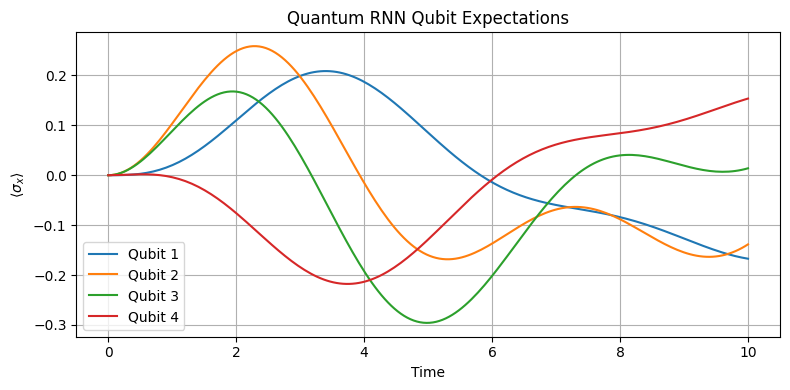

In [25]:
# Plot <σ_x> for each qubit
exp_x = np.zeros((len(t_pts), N))
for k, rho in enumerate(results):
    exp_x[k, :] = [qutip.expect(qrnn._tensor_op(qrnn.sx, i), rho)
                    for i in range(N)]


plt.figure(figsize=(8,4))
for i in range(N):
    plt.plot(t_pts, exp_x[:, i], label=f'Qubit {i+1}')
plt.xlabel('Time')
plt.ylabel(r'$\langle \sigma_x \rangle$')
plt.title('Quantum RNN Qubit Expectations')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

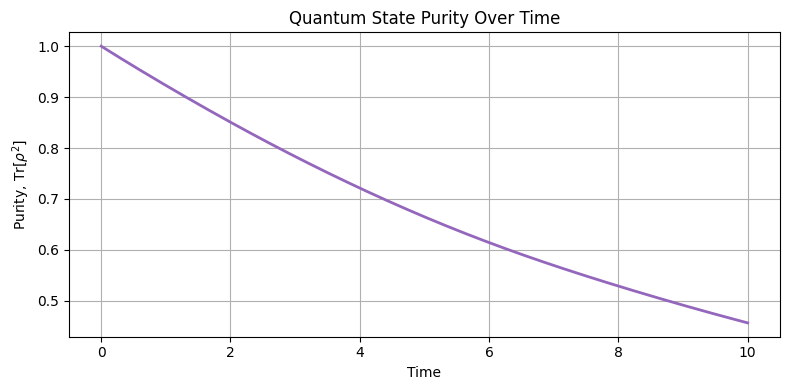

In [26]:
import numpy as np
import matplotlib.pyplot as plt

# … after evolution_results = qrnn.evolve(…) …

# Compute purity = Tr[ρ^2] at each time step
purities = np.array([np.real((rho * rho).tr()) for rho in results])

# Plot purity over time
plt.figure(figsize=(8,4))
plt.plot(t_pts, purities, color='tab:purple', lw=2)
plt.xlabel('Time')
plt.ylabel('Purity, Tr[$\\rho^2$]')
plt.title('Quantum State Purity Over Time')
plt.grid(True)
plt.tight_layout()
plt.show()


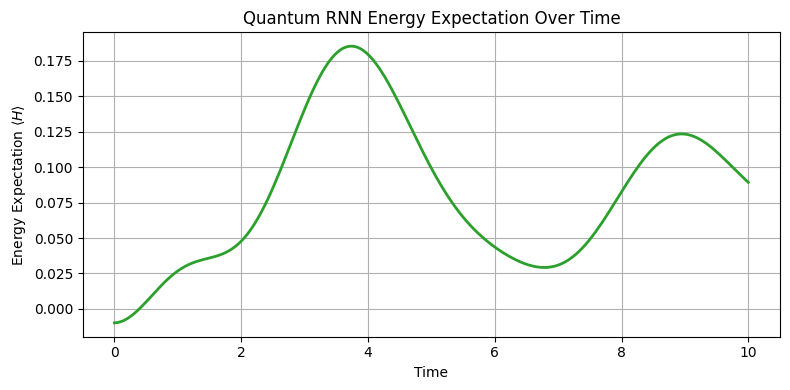

In [27]:
import numpy as np
import matplotlib.pyplot as plt

# Assume you have:
# - qrnn: your QuantumRNN instance
# - t_pts: 1D numpy array of time points
# - results: list of qutip.Qobj density matrices ρ(t)
# - And a function H_t(rho, t) that returns the Hamiltonian at time t
#   (e.g., qrnn._get_hamiltonian(rho, inputs(t)))

# Compute energy expectation at each time
energies = []
for idx, rho in enumerate(results):
    t = t_pts[idx]
    # Rebuild inputs if needed:
    inputs_t = inputs(t)                   # your time-dependent input fn
    H = qrnn._get_hamiltonian(rho, inputs_t)
    # <H> = Tr[ρ H]
    energies.append(np.real((rho * H).tr()))

# Plot
plt.figure(figsize=(8, 4))
plt.plot(t_pts, energies, color='tab:green', lw=2)
plt.xlabel('Time')
plt.ylabel(r'Energy Expectation $\langle H \rangle$')
plt.title('Quantum RNN Energy Expectation Over Time')
plt.grid(True)
plt.tight_layout()
plt.show()


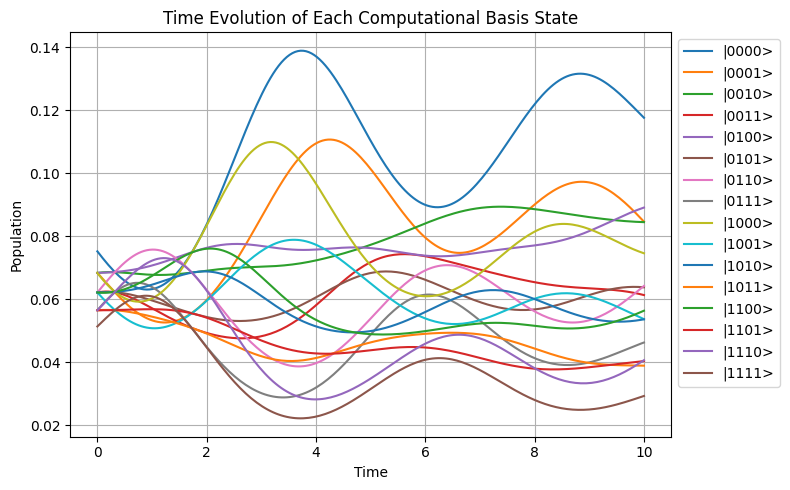

In [28]:
def plot_state_populations(results, t_pts, N):
    """
    Plots population of each computational basis state |i> over time.
    """
    num_states = 2**N
    # Extract populations: diagonal elements of each rho
    pop_matrix = np.array([rho.diag() for rho in results])  # shape (len(t_pts), num_states)

    plt.figure(figsize=(8, 5))
    for state_idx in range(num_states):
        plt.plot(t_pts, pop_matrix[:, state_idx], label=f"|{state_idx:0{N}b}>")
    plt.xlabel("Time")
    plt.ylabel("Population")
    plt.title("Time Evolution of Each Computational Basis State")
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Usage example (after your evolution):
N = 4
plot_state_populations(results, t_pts, N)